In [1]:
%matplotlib inline
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import csv
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import random
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
from copy import deepcopy
import networkx.algorithms.community.quality as nxq
import community as community_louvain

# Louvain Community detection algorithm

## Phase 1

In [5]:
def community_to_dict(communities):
    commu = {}
    for i, com in enumerate(communities):
        for node in com:
            commu[node] = i
    return commu

In [143]:
def from_dict_to_list(partition):
    num_com = max(partition.values())
    com = [[] for i in range(num_com+1)]
    for node in partition:
        com[partition[node]].append(node)
    return com

In [7]:
def find_community_i(community, i):
    for ind, com in enumerate(community):
        if i in com:
            return ind

In [9]:
def delete_from_com(community, ind, i):
    com = deepcopy(community)
    com[ind].remove(i)
    return com

In [11]:
def add_to_community(community, ind, i):
    com = deepcopy(community)
    com[ind].add(i)
    return com

In [13]:
def phase1(graph):

    # initialize the communities: each node in a different community
    communities = []
    for node in graph.nodes():
        communities.append({node})

    best_mod = nxq.modularity(graph, communities, weight='weight')
    best_community = communities

    count = 0
    while 1:
        count += 1
        for node in graph.nodes():
            com = deepcopy(best_community)
            ind_node = find_community_i(com, node)
            neigh_node = graph.neighbors(node)
            for neigh in neigh_node:
                com_bis = deepcopy(com)
                ind_neigh = find_community_i(com_bis, neigh)
                com_bis = delete_from_com(com_bis, ind_node, node)
                com_bis = add_to_community(com_bis, ind_neigh, node)
                com_bis = [s for s in com_bis if s != set()]
                mod = nxq.modularity(graph, com_bis, weight='weight') # Attention ca doit etre le gain de modularité
                if mod > best_mod:
                    best_mod = mod
                    best_community = com_bis.copy()
        if com == best_community:
            break
    best_community = [s for s in best_community if s != set()]
    return best_community, best_mod
    

In [14]:
def size_link_between_com(com1, com2, graph):

    link = 0
    for node1 in com1:
        for node2 in com2:
            data = graph.get_edge_data(node1, node2)
            if data != None:
                if data != {}:
                    link += data['weight']
                else:
                    link += 1
    return link

## Phase 2

In [15]:
def phase2(communities, graph):

    nodes = graph.nodes()
    edges = graph.edges()

    new_nodes = [i for i in range(len(communities))]
    new_edges = []

    new_graph = nx.Graph()
    new_graph.add_nodes_from([i for i in range(len(communities))])


    for i, com1 in enumerate(communities):
        for j, com2 in enumerate(communities):
            if i >= j:
                if i == j:
                    # self_loops
                    nodes_in_com = [node for node in com1]
                    subGraph = graph.subgraph(nodes_in_com)
                    new_edges.append((i,i, {'weight':subGraph.size(weight='weight')}))
                else:
                    link = size_link_between_com(com1, com2, graph)
                    if link > 0:
                        new_edges.append((i,j, {'weight':link}))

    new_graph.add_edges_from(new_edges)
    return new_graph

In [123]:
def merge_communities(communities, best_communities):

    new_communities = []

    for com in best_communities:
        uni = set()
        for element in com:
            uni = uni.union(communities[element])
        new_communities.append(uni)
    return new_communities  


def find_community_i(community, i):
    for ind, com in enumerate(community):
        if i in com:
            return ind

def merge_communities_first(communities, best_communities):

    new_communities = []

    for com in best_communities:
        uni = set()
        for element in com:
            index = find_community_i(communities, element)
            uni = uni.union(communities[index])
        new_communities.append(uni)
    return new_communities      

In [18]:
def load_graph(file_path):
    assert ('txt' in file_path), 'Please choose a graph file of type txt'

    G = nx.read_edgelist(file_path,create_using=nx.Graph(), nodetype = int)
    return G

In [125]:
def louvain_algorithm(G):

    prev_best_community, prev_best_mod = None, None
    communities = []
    for node in G.nodes():
        communities.append({node})

    First = True

    while 1:

        print('phase1')
        best_communities, best_mod = phase1(G)

        print('phase2')
        G = phase2(best_communities, G)

        if best_mod == prev_best_mod:
            break
        else:
            prev_best_community, prev_best_mod = best_communities, best_mod

        if First:
            First = False
            communities = merge_communities_first(communities, best_communities)
        else:
            communities = merge_communities(communities, best_communities)

    return communities, best_mod

# Test

## Karate club graph

In [136]:
import unittest
import math

class PylouvainTest(unittest.TestCase):

    def test_karate_club(self):
        G = load_graph('karate.txt')
        partition, q = louvain_algorithm(G)
        print(f'Best modularity found: {q}')
        q_ = q * 10000
        self.assertEqual(4, len(partition))
        self.assertEqual(4298, math.floor(q_))
        self.assertEqual(4299, math.ceil(q_))

In [137]:
PylouvainTest().test_karate_club()

phase1
phase2
phase1
phase2
phase1
phase2
Best modularity found: 0.42983639736886486


phase1
phase2
phase1
phase2
phase1
phase2
Best modularity found: 0.42983639736886486


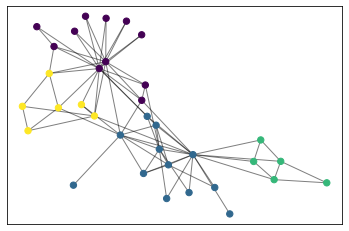

In [142]:
import matplotlib.cm as cm

G = load_graph('karate.txt')
partition, q = louvain_algorithm(G)
partition = community_to_dict(partition)
print(f'Best modularity found: {q}')
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Best modularity found: 0.4298363973688648


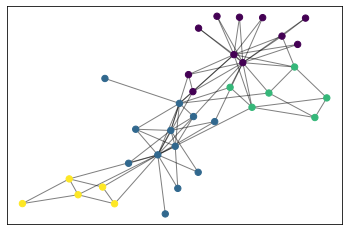

In [144]:
# Comparing with the open source implementation
import community as community_louvain
import matplotlib.cm as cm

# load the karate club graph
G = nx.read_edgelist('karate.txt',create_using=nx.Graph(), nodetype = int)

# compute the best partition
partition = community_louvain.best_partition(G)
print(f'Best modularity found: {community_louvain.modularity(partition, G)}')

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

## Youtube graph

In [146]:
G = load_graph('com-youtube.ungraph.txt')
nodes = list(G.nodes())
G_sub = G.subgraph(nodes[0:100])

phase1
phase2
phase1
phase2
phase1
phase2
phase1
phase2
Best modularity found: 0.17158743832719867


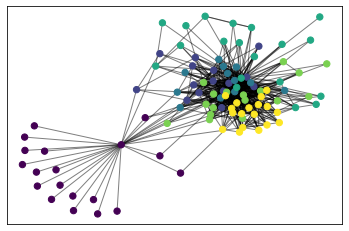

In [148]:
import matplotlib.cm as cm

partition, q = louvain_algorithm(G_sub)
partition = community_to_dict(partition)
print(f'Best modularity found: {q}')
# draw the graph
pos = nx.spring_layout(G_sub)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_sub, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_sub, pos, alpha=0.5)
plt.show()

Best modularity found: 0.17495496906570598


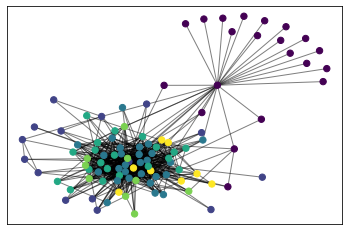

In [147]:
# compute the best partition
partition = community_louvain.best_partition(G_sub)
print(f'Best modularity found: {community_louvain.modularity(partition, G_sub)}')

# draw the graph
pos = nx.spring_layout(G_sub)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_sub, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_sub, pos, alpha=0.5)
plt.show()